# Simulation_CLP_PID_FF

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from matplotlib import colors as mcolors

import package_DBR
from package_DBR import myRound, SelectPath_RT, Delay_RT, FO_RT, FOPDT, SOPDT, FOPDT_cost, SOPDT_cost, Process, Bode

import package_LAB
from package_LAB import LeadLag_RT, PID_RT, IMCTuning

from importlib import reload
package_DBR = reload(package_DBR)
package_LAB = reload(package_LAB)

# Simulation parameters

In [2]:
TSim = 2200
Ts = 1
N = int(TSim/Ts) + 1

# Working point
MV0 = 70
DV0 = 50
PV0 = 55

# Parameters for input-output dynamics
Kp = 0.39017974996276006
T1p = 116.66713066631694
T2p = 5.8799095225973697e-05
thetap = 8.040136542300573

# Parameters for disturbance dynamics
Kd = 0.25528292889822546
T1d = 111.28768815478185
T2d = 13.096105965625204
thetad = 8.350157927710411

# Parameters PID controller
gamma = 0.8
Kc,Ti,Td = IMCTuning(Kp,T1p,T2p,thetap,gamma,'SOPDT')

print(Kc)
print(Ti)
print(Td)

alpha = 0.6
MVMin = 0
MVMax = 100


Kc = 5
#Ti = 200
#Td = 10
#alpha = 0.6

2.9495659245996975
116.66718946541216
5.879906559181849e-05


# Simultation input signals

In [3]:
# Scenario 1: OLP + no FF OK
#ManPath = {0: True,TSim: True} # Path for Man
#MVManPath = {0: MV0, TSim: MV0} # Path for MVMan
#SPPath = {0: PV0, TSim: MV0} # Path for SP
#DVPath = {0: 50.0, 1000: 60, TSim: 60.0} # Path for DV
#ActivateFF = False
#ManFF = True

# Scenario 2: OLP + FF OK
#ManPath = {0: True,TSim: True} # Path for Man
#MVManPath = {0: MV0, TSim: MV0} # Path for MVMan
#SPPath = {0: PV0, TSim: MV0} # Path for SP
#DVPath = {0: 50.0, 1000: 60, TSim: 60.0} # Path for DV
#ActivateFF = True
#ManFF = True

# Scenario 3: CLP + no FF
ManPath = {0: True, 750: False, TSim: False} # Path for Man
MVManPath = {0: MV0, TSim: MV0} # Path for MVMan
SPPath = {0: PV0, 800: PV0-10, TSim: PV0-10} # Path for SP
DVPath = {0: DV0, 1500: DV0+10, TSim: DV0+10} # Path for DV
ActivateFF = False
ManFF = False

# Scenario 4: CLP + FF
#ManPath = {0: True, 750: False, TSim: False} # Path for Man
#MVManPath = {0: MV0, TSim: MV0} # Path for MVMan
#SPPath = {0: PV0, 800: PV0-10, TSim: PV0-10} # Path for SP
#DVPath = {0: DV0, 1500: DV0+10, TSim: DV0+10} # Path for DV
#ActivateFF = True
#ManFF = False

# Closed-loop simulation with PID and FF

(0.0, 2200.0)

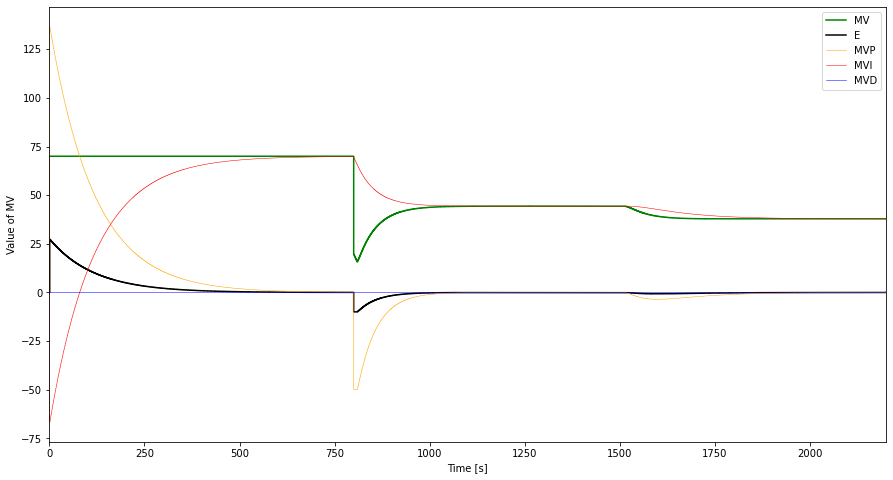

In [4]:
t = []
SP = []
MV = []
Man = []
MVMan = []
MVFF = []
MVP = []
MVI = []
MVD = []
DV = []
PV = []
E = []

MVFFDelay = []
MVFFLL1 = []

MVDelayp = []
PV1p = []
PV2p = []

MVDelayd = []
PV1d = []
PV2d = []

for i in range(0,N):
    t.append(i*Ts)
    
    # Input signals SP and DV
    SelectPath_RT(SPPath,t,SP)
    SelectPath_RT(DVPath,t,DV)
    
    # Feedforward
    Delay_RT(DV - DV0*np.ones_like(DV),np.max([thetad-thetap,0]),Ts,MVFFDelay)
    LeadLag_RT(MVFFDelay,-Kd/Kp,T1p,T1d,Ts,MVFFLL1)
    if ActivateFF:
        LeadLag_RT(MVFFLL1,1,T2p,T2d,Ts,MVFF)
    else:
        LeadLag_RT(MVFFLL1,0,T2p,T2d,Ts,MVFF)

    # PID controller mode
    SelectPath_RT(ManPath,t,Man)
    SelectPath_RT(MVManPath,t,MVMan)
    
    # PID control action
    PID_RT(SP,PV,Man,MVMan,MVFF,Kc,Ti,Td,alpha,Ts,MVMin,MVMax,MV,MVP,MVI,MVD,E,ManFF,PV0)
    
    # Input-output dynamics P(s)
    Delay_RT(MV,thetap,Ts,MVDelayp,MV0)
    FO_RT(MVDelayp,Kp,T1p,Ts,PV1p,0)
    FO_RT(PV1p,1,T2p,Ts,PV2p,0)
    
    # Input-output dynamics D(s)
    Delay_RT(DV - DV0*np.ones_like(DV),thetad,Ts,MVDelayd,0)
    FO_RT(MVDelayd,Kd,T1d,Ts,PV1d,0)
    FO_RT(PV1d,1,T2d,Ts,PV2d,0)
    
    PV.append(PV2p[-1] + PV2d[-1] + PV0-Kp*MV0)

    
plt.figure(figsize = (15,8))
plt.step(t,MV,'g-',label='MV',where='post')
plt.step(t,E,'black',label='E',where='post')
plt.step(t,MVP,'orange',label='MVP',where='post',linewidth=0.5)
plt.step(t,MVI,'red',label='MVI',where='post',linewidth=0.5)
plt.step(t,MVD,'blue',label='MVD',where='post',linewidth=0.5)
plt.ylabel('Value of MV')
plt.xlabel('Time [s]')
plt.legend(loc='best')
plt.xlim([0, TSim])  


# Plot data

(45.0, 65.0)

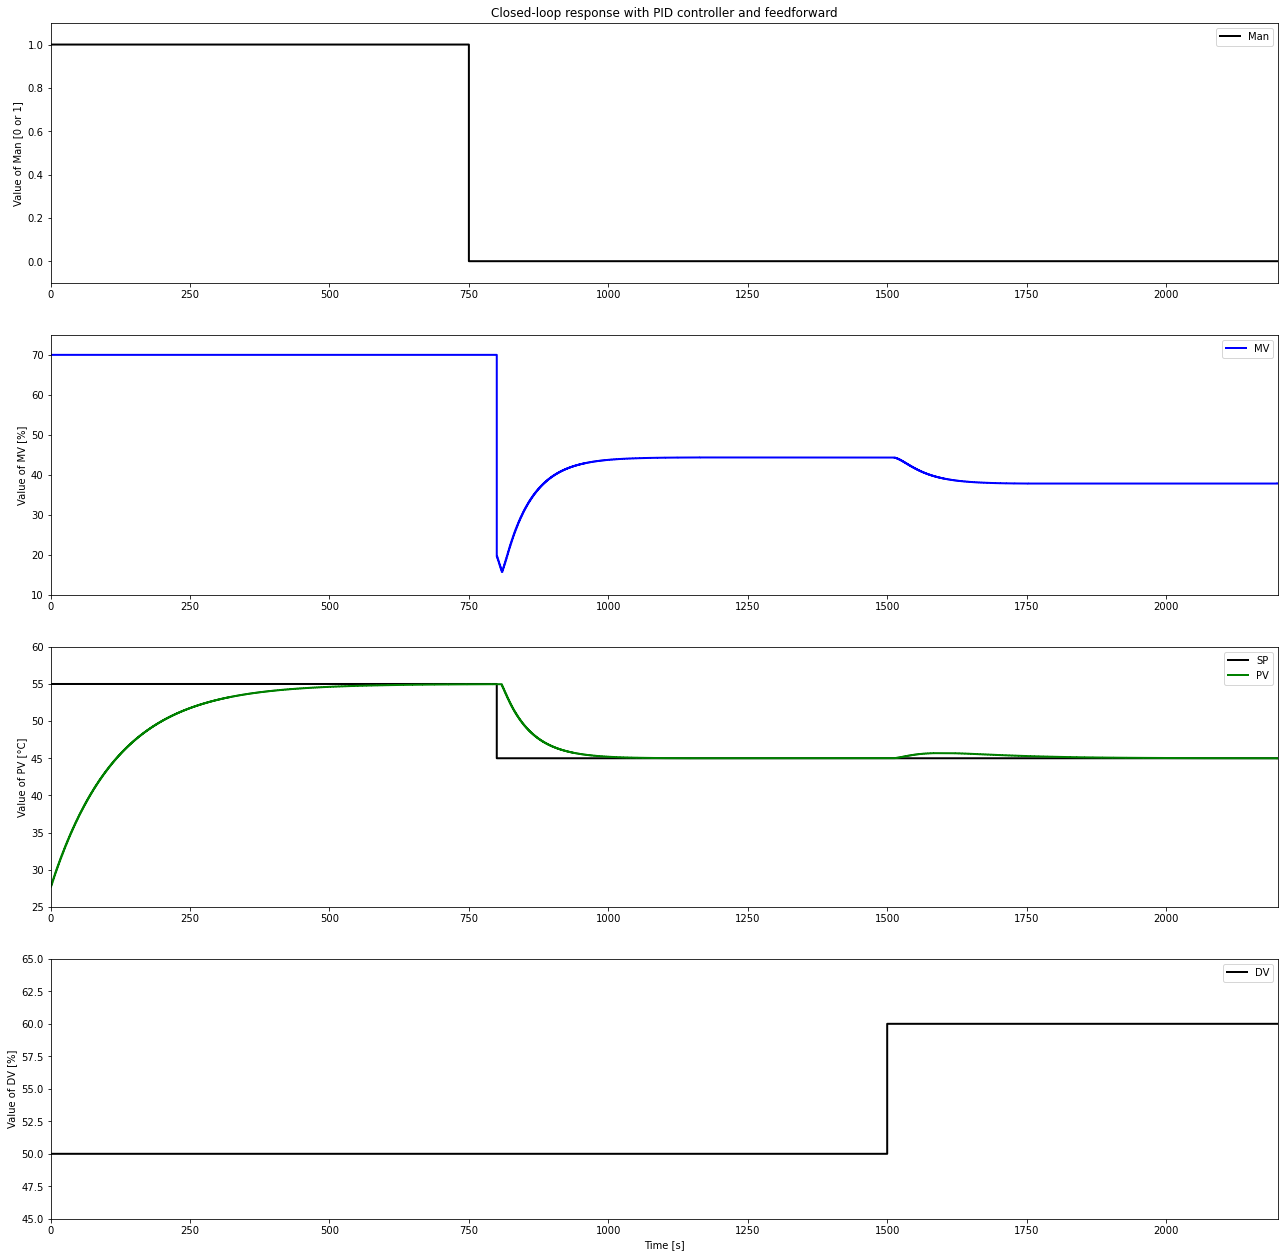

In [5]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1)
fig.set_figheight(22)
fig.set_figwidth(22)

l1, = ax1.step([0,t[-1]],[0,100],'k-',linewidth=2,label='Man',where='post')
ax1.set_ylabel('Value of Man [0 or 1]')
ax1.set_title('Closed-loop response with PID controller and feedforward')
ax1.legend(loc='best')

l2, = ax2.step([0,t[-1]],[0,100],'b-',linewidth=2,label='MV',where='post')
ax2.set_ylabel('Value of MV [%]')
ax2.legend(loc='best')

l3, = ax3.step([0,t[-1]],[0,100],'k-',linewidth=2,label='SP',where='post')
l4, = ax3.step([0,t[-1]],[0,100],'g-',linewidth=2,label='PV',where='post')
ax3.set_ylabel('Value of PV [°C]')
ax3.legend(loc='best')

l5, = ax4.step([0,t[-1]],[0,100],'k-',linewidth=2,label='DV',where='post')
ax4.set_xlabel('Time [s]')
ax4.set_ylabel('Value of DV [%]')
ax4.legend(loc='best')

ManInt = [int(x) for x in Man]
l1.set_data(t,ManInt)
l2.set_data(t,MV)
l3.set_data(t,SP)
l4.set_data(t,PV)
l5.set_data(t,DV)

ax1.set_xlim(0,t[-1]+1)
ax2.set_xlim(0,t[-1]+1)
ax3.set_xlim(0,t[-1]+1)
ax4.set_xlim(0,t[-1]+1)

ax1.set_ylim(-0.1,1.1)
ax2.set_ylim(myRound(np.min(MV),5)-5,myRound(np.max(MV),5)+5)
ax3.set_ylim(myRound(np.min((np.min(PV),np.min(SP))),5)-5,myRound(np.max((np.max(PV),np.max(SP))),5)+5)
ax4.set_ylim(myRound(np.min(DV),5)-5,myRound(np.max(DV),5)+5)